In [1]:
import pandas as pd
import numpy as np
import random
import collections
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import operator   

## import dataset

In [2]:
df = pd.read_excel('Firefighter_food_time_HealthDataSet.xlsx')

In [3]:
df['group'] = ['baseline' if x  <= 14 else 'intervention' for x in df['Day since beginning of participant enrollment']]

In [4]:
len(df['Participant ID'].unique())

137

In [5]:
df=df[(df['Beverage(b)/Food(f)/Water(w)/medication(m)']=='f') | (df['Beverage(b)/Food(f)/Water(w)/medication(m)']=='b')]


## Data Cleaning

First, delete firefighter data with less than 10 days of entries since such data are not what we want to analyze

In [6]:
par_to_drop = []
for index, value in df['Participant ID'].value_counts().iteritems():

    if value < 10:
        par_to_drop.append(index)


In [7]:
df_by_par = df.set_index('Participant ID')

In [8]:
for par in par_to_drop:
    df_by_par.drop(par,inplace=True)

In [9]:
df = df_by_par.reset_index()

## Revise column name

In [10]:
df.rename({'Participant ID':'ParticipantID'}, axis='columns',inplace=True)
df.rename({'Day since beginning of participant enrollment':'DayPassed'}, axis='columns',inplace=True)

## Analysis

In [11]:
# set index
df_index = df.set_index(['ParticipantID','Date'])

check whether everyone have  roughly 14 days of entries in baseline.

check the maximum number of continuous days of records each participant has since the first day of baseline and intervention. This could provide some background information that could be useful for further analysis.

In [12]:

df_check = pd.DataFrame(df['ParticipantID'].unique())
df_check.rename({0:'ParticipantID'}, axis='columns',inplace=True)

In [13]:
df_check

,ParticipantID
0,9bbi18050005
1,9bbi18050009
2,9bbi18050011
3,9bbi18060012
4,9bbi18060013
...,...
131,9bbi19110168
132,9bbi19110169
133,9bbi19110171
134,9bbi19120173


'BaselineCheck' contains boolean values, indicating whether the participants has at least 12 days of record during baseline. We do not choose the threshold of 14 days here since doing that would exclude too many participants in our study.

'BaselineContinuous' and 'InterventionContinuous' contains numerical values, indicating how many continuous days of record each individual has since the start of baseline/intervention.

In [14]:
df_check['BaselineCheck'] = [False]*136
df_check['BaselineContinuous'] = np.repeat(0,136)
df_check['InterventionContinuous'] = np.repeat(0,136)
df_check.set_index(['ParticipantID'])

,BaselineCheck,BaselineContinuous,InterventionContinuous
ParticipantID,,,
9bbi18050005,False,0,0
9bbi18050009,False,0,0
9bbi18050011,False,0,0
9bbi18060012,False,0,0
9bbi18060013,False,0,0
...,...,...,...
9bbi19110168,False,0,0
9bbi19110169,False,0,0
9bbi19110171,False,0,0


In [15]:
# check whether everyone has more than 12 days in baseline record
arr = []
for parID in df['ParticipantID'].unique():

    length = len(df_index.query('ParticipantID == @parID and group == "baseline"')['DayPassed'].unique())
    if length >= 12:
        arr.append(True)
    else:
        arr.append(False)
df_check['BaselineCheck'] = arr

In [16]:
df_check

,ParticipantID,BaselineCheck,BaselineContinuous,InterventionContinuous
0,9bbi18050005,True,0,0
1,9bbi18050009,True,0,0
2,9bbi18050011,True,0,0
3,9bbi18060012,True,0,0
4,9bbi18060013,True,0,0
...,...,...,...,...
131,9bbi19110168,True,0,0
132,9bbi19110169,True,0,0
133,9bbi19110171,True,0,0
134,9bbi19120173,True,0,0


In [17]:
# check how many continuous days each have
def check_continuous(l):
    start = l[0]
    count = 1
    for day in l[1:]:
        if day == start + 1:
            count +=1
            start = day
        else: break
    return count

In [18]:
# check how many continuous days each have in baseline
arr = []
for parID in df['ParticipantID'].unique():

    daylist = df_index.query('ParticipantID == @parID and group == "baseline"')['DayPassed'].unique()
    count = check_continuous(daylist)
    arr.append(count)
df_check['BaselineContinuous'] = arr    

In [19]:
# check how many continuous days each have in intervention
arr = []
for parID in df['ParticipantID'].unique():

    daylist = df_index.query('ParticipantID == @parID and group == "intervention"')['DayPassed'].unique()
    count = check_continuous(daylist)
    arr.append(count)
df_check['InterventionContinuous'] = arr    

In [20]:
df_check

,ParticipantID,BaselineCheck,BaselineContinuous,InterventionContinuous
0,9bbi18050005,True,15,30
1,9bbi18050009,True,15,7
2,9bbi18050011,True,15,3
3,9bbi18060012,True,12,4
4,9bbi18060013,True,12,60
...,...,...,...,...
131,9bbi19110168,True,15,28
132,9bbi19110169,True,15,9
133,9bbi19110171,True,15,109
134,9bbi19120173,True,15,52


In [21]:
# drop participants whose Baseline Check is False (who has less than 12 days of record during baseline)
par_drop = np.array(df_check.query('BaselineCheck == False')['ParticipantID'])
df_index.reset_index(inplace=True)

df_index.set_index(['ParticipantID'],inplace=True)
for par in par_drop:
    df_index.drop(par,inplace=True)
df_index.reset_index(inplace=True)
df_index.set_index(['ParticipantID','Date'],inplace=True)

In [22]:
df_index.reset_index(inplace=True)
all_date_base = df_index['Date'].unique()
all_par_base = df_index['ParticipantID'].unique()
df_index.set_index(['ParticipantID','Date'],inplace=True)

In [23]:
all_date = df['Date'].unique()

In [24]:
all_par = df['ParticipantID'].unique()

Create several food dictionaries for future use. Each food dictionary has a double dictionary structure. For such a dictionary, keys are the unique ID of valid participants in the study. For each key, its corresponding value is another dictionary, with keys being the TimeStamp of the date that he or she made a record, and with values being the food items that he or she record during that day.

food_dict is a food dictionary containing all participants and all days in this experiment. 

food_dict_base is a food dictionary containing all participants but only the days in baseline in this experiement.

In [25]:
#make food log a dictionary for all days in experiment

food_dict= {}
for par in all_par:
    food_dict[par] = {}
    
    df_temp = df_index.query('ParticipantID == @par')
    df_temp.reset_index(inplace=True)
    dates = df_temp['Date'].unique()
    for date in dates:
        df_temp2 = df_temp.query('Date == @date')
    
        for index, value in df_temp2['Parsed food'].iteritems():
            if date not in food_dict[par].keys():
                food_dict[par][date] = [value]
            else:
                 food_dict[par][date].append(value)


In [26]:
#make food log for baseline only (0-14 days)

food_dict_base= {}
for par in all_par_base:
    food_dict_base[par] = {}
    
    df_temp = df_index.query('ParticipantID == @par and DayPassed <= 14')
    df_temp.reset_index(inplace=True)
    dates = df_temp['Date'].unique()
    for date in dates:
        df_temp2 = df_temp.query('Date == @date')
    
        for index, value in df_temp2['Parsed food'].iteritems():
            if date not in food_dict_base[par].keys():
                food_dict_base[par][date] = [value]
            else:
                 food_dict_base[par][date].append(value)

## Data sampling methods

In [27]:
#random subsample 
# for each participant, randomly sample 1,3,7,10,14days (n days)
"""
Generate random sampling of n days for participant parID

Parameter: 
----------
ndays: number of days we want the random sampling to contain
parID: the participant whom we want to sample data from

Return:
---------
food_par: an array containing food items that we sampled

"""
def random_sample(ndays,parID):
    food_dict_par = food_dict_base[parID]
    keys = food_dict_par.keys()
    if len(keys) >= ndays:
        days_sampled = random.sample(keys, ndays) 
        food_par = []
        for day in days_sampled:
            food_par += food_dict_par[day]
        return food_par
    else:
        #return false if the participant do not have enough data
        return False
    

In [28]:
# for each participant, sample consecutively n days
"""
Generate random consecutive sampling of n days for participant parID

Parameter: 
----------
ndays: number of days we want the random consecutive sampling to contain
parID: the participant whom we want to sample data from

Return:
---------
food_par: an array containing food items that we sampled

"""
def consecutive_sample(ndays,parID):
    food_dict_par = food_dict_base[parID]
    keys = list(food_dict_par.keys())

    if len(keys) >= ndays:
        start = random.choice(range(0,len(keys)-ndays+1))
        food_par = []
        for i in range(ndays):
            food_par += food_dict_par[keys[start]]
            start+=1
        return food_par
    else:
         #return false if the participant do not have enough data
        return False

In [29]:
# calculate overlap score of 2 food lists
def cal_overlap(l1,l2):
    n_overlap = 0
    for item in l1:
        if item in l2:
            n_overlap +=1
    return n_overlap/len(l2)
    

In [30]:
# calculate overlap score of n_days sampling vs baseline (0-14). In such comparison, we regard the baseline as the ground truth.
"""
calculate overlap score of the most k frequent food items of the n_days sampling within the baseline and that of the entire baseline (0-14day) 

Parameter: 
----------
ndays: number of days we want the sampling to contain
parID: the participant whom we want to sample data from
typed: the type of sampling we want to uses ('random' or 'consecutive')
k: number of most frequent food items we want to compare

Return:
---------
return the mean of the overlap scores of the participant throughout 1000 iterations

"""
def get_random_sample(n_days,parID,typed,k):
   
    par_food = []
    for key,value in  food_dict_base[parID].items():
        par_food += value
    index = 0
    top_k_all = []
    frequency_all = dict(collections.Counter(par_food))
    
    freq_all = sorted(frequency_all.items(), key=lambda kv: kv[1],reverse=True)
    

    for item,freq in freq_all:
        if index < k:
            top_k_all.append(item)
            index+=1
        else:
            break
    overlap = []
    
    #repeat for 1000 times to minimize the influence of outlier
    for i in range(1000):
        if typed == 'random':
            food_par = random_sample(n_days,parID)
        if typed == 'consecutive':
            food_par = consecutive_sample(n_days,parID)        
  
        frequency = dict(collections.Counter(food_par))
    
        freq = sorted(frequency.items(), key=lambda kv: kv[1],reverse=True)
        
        index = 0
        sample_k = []
        for item,freq in freq:
            if index < k:
                sample_k.append(item)
                index+=1
            else:
                break
        
        
        percent_overlap = cal_overlap(sample_k,top_k_all)
        overlap.append(percent_overlap)

    return statistics.mean(overlap)

In [31]:

"""
Calculte overlap scores of the results from 2 sampling methods

Parameter: 
----------
day: number of days to sample as the "ground truth"
par: number of days to sample as comparison
parID: the participant whom we want to sample data from
typed: the type of sampling we want to uses ('random' or 'consecutive')
k: number of most frequent food items we want to compare

Return:
---------
return the overlap score of results from 2 sampling methods

"""
def compare_subsample(day,pair,typed,parID,k):
        #k_dict={1:3,3:4,7:5,10:7,14:10}
        if typed == 'random':
            food_par1 = random_sample(day,parID)
            food_par2 = random_sample(pair,parID)
        if typed == 'consecutive':
            food_par1 = consecutive_sample(day,parID)
            food_par2 = consecutive_sample(pair,parID)

            
        # using Counter to find frequency of elements
        frequency1 = dict(collections.Counter(food_par1))
        frequency2 = dict(collections.Counter(food_par2))



        freq1 = sorted(frequency1.items(), key=lambda kv: kv[1],reverse=True)
        freq2 = sorted(frequency2.items(), key=lambda kv: kv[1],reverse=True)

        # get the most k frequent food items from sample1
        index = 0
        sample_k1 = []
        for item,freq in freq1:
            if index < k:
                sample_k1.append(item)
                index+=1
            else:
                break
        
        # get the most k frequent items from sample2
        index = 0
        sample_k2 = []
        for item,freq in freq2:
            if index < k:
                sample_k2.append(item)
                index+=1
            else:
                break
        


        percent_overlap = cal_overlap(sample_k1,sample_k2)
        return percent_overlap



In [32]:

"""
Monte-Carlo way to compare different sampling methods. Here we take each sampling method as ground truth iteratively, 
and compare its performance with other methods. For the sampling part, we draw samples within the baseline.

Parameter: 
----------
typed: the type of sampling we want to uses ('random' or 'consecutive')
k: number of most frequent food items we want to compare

Return:
---------
final_result: 2d array of size 4*4 containing averaged overlap scores over the 1000 iterations of the comparisons, with row index and column index indicating different sampling methods
final_overlap: 3d array of size 4*4*1000 containing raw overlap scores of the comparisons.
For these 2 matrices, we only fill out the upper triangle part
"""
def calculate_overlap(typed,k):
   
    day_dict={1:0,3:1,7:2,10:3,14:4}
    
    total_result = []
    total_overlap = []

    days = [1,3,7,10]
    for parID in list(food_dict_base.keys()):
        
        overlap_arr = []
        line = []
        for i in range (0, 4):
            for j in range(0,4):
                line.append(np.zeros(1000))
            overlap_arr.append(np.copy(line))
            line = []

            
        result = np.zeros((4,4))
        
        # compare with other sampline methods
        for day in days:
            pairs = [x for x in days if x != day and x>day]
            for pair in pairs:
                overlap = [] #contains 1000 percentages
                for i in range(1000):
                     
                    overlap.append(compare_subsample(day,pair,typed,parID,k))
                overlap_result = statistics.mean(overlap)
                
                
                result[day_dict[day],day_dict[pair]] = overlap_result
                overlap_arr[day_dict[day]][day_dict[pair]] = np.array(np.copy(overlap))
        
        total_result.append(np.copy(result))
        total_overlap.append(np.copy(overlap_arr))
   
        
        
    final_result = np.asarray(total_result).mean(axis = 0)
    final_overlap = np.asarray(total_overlap).mean(axis=0)
            
                
    return final_result,final_overlap
   

In [33]:
result,overlap_arr = calculate_overlap('random',4)

In [34]:
result1,overlap_arr1 = calculate_overlap('random',10)

In [35]:
result2,overlap_arr = calculate_overlap('random',6)

In [36]:
result #k=4 

array([[0.        , 0.18958656, 0.2207668 , 0.22998643],
       [0.        , 0.        , 0.40566537, 0.43144574],
       [0.        , 0.        , 0.        , 0.60882171],
       [0.        , 0.        , 0.        , 0.        ]])

In [37]:
result2 # k=6

array([[0.        , 0.20607106, 0.24366641, 0.25612016],
       [0.        , 0.        , 0.39531537, 0.42169251],
       [0.        , 0.        , 0.        , 0.60015633],
       [0.        , 0.        , 0.        , 0.        ]])

In [38]:
result1 #k=10

array([[0.        , 0.21588216, 0.2571821 , 0.27358052],
       [0.        , 0.        , 0.39276484, 0.41952743],
       [0.        , 0.        , 0.        , 0.58955361],
       [0.        , 0.        , 0.        , 0.        ]])

[Text(0, 0.5, '1'), Text(0, 1.5, '3'), Text(0, 2.5, '7'), Text(0, 3.5, '10')]

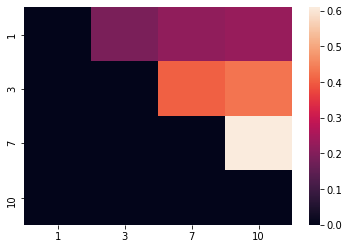

In [74]:
# plot heatmap for monte-carlo comparison
ax = sns.heatmap(result)
ax.set_xticklabels([1,3,7,10])
ax.set_yticklabels([1,3,7,10])

In [40]:
# create dataframe for comparison result and calculate mean, median, and standard deviation
num_list = [str(x) for x in list(range(1,1001))]

df = pd.DataFrame(columns = ['comparison']+num_list)
df['comparison'] = ['1v3', '1v7', '1v10','1v14','3v7','3v10','3v14','7v10','7v14','10v14']
df.set_index(['comparison'],inplace=True)
inverse_dict={0:1,1:3,2:7,3:10}
for i in range(0,4):
    for j in range(0,4):
        if j > i:
            string = str(inverse_dict[i])+'v'+str(inverse_dict[j])
            df.loc[string] = overlap_arr[i][j]
df_copy = df.copy()
df['mean'] = df_copy.mean(axis = 1)
df['median'] = df_copy.median(axis = 1)
df['std'] = df_copy.std(axis=1)
df

/Users/suijialu/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:995: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


,1,2,3,4,5,6,7,8,9,10,...,994,995,996,997,998,999,1000,mean,median,std
comparison,,,,,,,,,,,,,,,,,,,,,
1v3,0.191214,0.226098,0.195866,0.222997,0.197028,0.213824,0.20801,0.214729,0.196382,0.200775,...,0.212532,0.197674,0.213178,0.197158,0.23385,0.181525,0.209302,0.206071,0.206460,0.017163
1v7,0.219638,0.244186,0.25323,0.223514,0.250646,0.254522,0.263566,0.23385,0.248062,0.241602,...,0.236434,0.222222,0.271318,0.249354,0.22739,0.2677,0.239018,0.243666,0.242894,0.015202
1v10,0.242894,0.237726,0.258398,0.275194,0.293282,0.254522,0.264858,0.244186,0.236434,0.24677,...,0.258398,0.248062,0.198966,0.239018,0.264858,0.248062,0.23385,0.256120,0.255814,0.015246
1v14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3v7,0.381137,0.414729,0.388889,0.401809,0.416021,0.386305,0.418605,0.388889,0.379845,0.403101,...,0.400517,0.396641,0.401809,0.390181,0.409561,0.396641,0.394057,0.395315,0.395349,0.015361
3v10,0.422481,0.428941,0.414729,0.410853,0.431525,0.428941,0.425065,0.432817,0.449612,0.409561,...,0.443152,0.418605,0.412145,0.435401,0.416021,0.413437,0.401809,0.421693,0.421189,0.015419
3v14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7v10,0.596899,0.609819,0.600775,0.607235,0.609819,0.620155,0.605943,0.590439,0.599483,0.571059,...,0.589147,0.593023,0.574935,0.617571,0.616279,0.595607,0.614987,0.600156,0.599483,0.014206
7v14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
# run distribution of ndays sampling vs baseline
# do not fix k here

def run_distribution(typed):
    total_result = []
    df1 = pd.DataFrame(columns = ['participant','day','overlap'])
    
    newlist = [item for items in  [[x]*4 for x in list(food_dict_base.keys())] for item in items]
    df1['participant'] = newlist

    df1['day'] = [float(x) for x in ['1','3','7','10']*129]
    #np.repeat()
    
    df1 = df1.sort_index()
    for parID in list(food_dict_base.keys()):
        percent_arr = []
        for (n_days,k) in zip([1,3,7,10],[3,4,5,7]):
            result = get_random_sample(n_days,parID,typed,k)
            percent_arr.append(result)
           
        total_result.append(np.copy(percent_arr))
        
        
    
    overlap_df = np.array(total_result).flatten()

    df1['overlap'] = overlap_df
    result = np.asarray(total_result).mean(axis = 0)
    print(result)

    #plt.figure(figsize=(6, 6))
    #plt.plot([1,3,7,10],result)
    
    sns.lineplot(data=df1, x="day", y="overlap")

    
    return df1
    
    

In [42]:
# run distribution of ndays sampling vs baseline
# use fixed k here
def run_distribution_k(typed,k):
    total_result = []
    df1 = pd.DataFrame(columns = ['participant','day','overlap'])
    
    newlist = [item for items in  [[x]*4 for x in list(food_dict_base.keys())] for item in items]
    df1['participant'] = newlist

    df1['day'] = [float(x) for x in ['1','3','7','10']*129]
    #np.repeat()
    
    df1 = df1.sort_index()
    for parID in list(food_dict_base.keys()):
        percent_arr = []
        for n_days in [1,3,7,10]:
            result = get_random_sample(n_days,parID,typed,k)
            percent_arr.append(result)
           
        total_result.append(np.copy(percent_arr))
        
        
    
    overlap_df = np.array(total_result).flatten()

    df1['overlap'] = overlap_df
    result = np.asarray(total_result).mean(axis = 0)
    print(result)

    #plt.figure(figsize=(6, 6))
    #plt.plot([1,3,7,10],result)
    
    sns.lineplot(data=df1, x="day", y="overlap")

    
    return df1
    
    

[0.21955039 0.45550646 0.6625168  0.76210336]


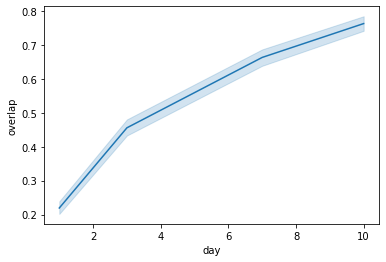

In [43]:
df = run_distribution_k('random',3)

[0.22239018 0.45066085 0.65285426 0.74342082]


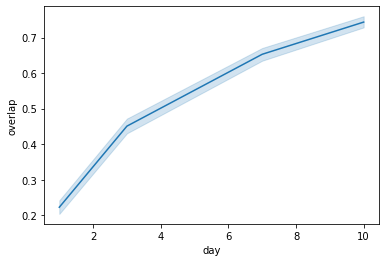

In [44]:
df = run_distribution('random')


[0.22053488 0.43862984 0.62907442 0.72993577]


,participant,day,overlap
0,9bbi18050005,1.0,0.293333
1,9bbi18050005,3.0,0.459500
2,9bbi18050005,7.0,0.497800
3,9bbi18050005,10.0,0.482429
4,9bbi18050009,1.0,0.114667
...,...,...,...
511,9bbi19120173,10.0,0.649000
512,9bbj18110064,1.0,0.293333
513,9bbj18110064,3.0,0.627750
514,9bbj18110064,7.0,0.828600


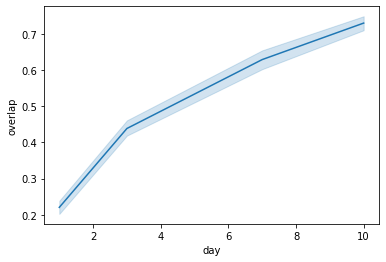

In [47]:
run_distribution('consecutive')

In [48]:
# check how many days of record each participant has
days_for_par = {}
for parID in list(food_dict.keys()):
    days_for_par[parID] = len(food_dict[parID])
days_for_par = sorted(days_for_par.items(), key=lambda kv: kv[1],reverse=True)
days_for_par


[('9bbi18100060', 384),
 ('9bbi19010071', 379),
 ('9bbi18080049', 369),
 ('9bbi18080047', 363),
 ('9bbi19050121', 352),
 ('9bbi19030090', 351),
 ('9bbi18070037', 348),
 ('9bbi18060018', 339),
 ('9bbi18060028', 336),
 ('9bbi19030095', 325),
 ('9bbi19040105', 325),
 ('9bbi19020076', 324),
 ('9bbi19040114', 324),
 ('9bbi18120067', 321),
 ('9bbi18100062', 318),
 ('9bbi18080050', 313),
 ('9bbi19030093', 313),
 ('9bbi18100061', 311),
 ('9bbi18120070', 307),
 ('9bbi18060034', 305),
 ('9bbi18080051', 300),
 ('9bbi19020077', 298),
 ('9bbi18050009', 271),
 ('9bbi19030094', 267),
 ('9bbi18120071', 265),
 ('9bbi18070039', 260),
 ('9bbi19040104', 259),
 ('9bbi19040112', 259),
 ('9bbi18070044', 257),
 ('9bbi19020074', 254),
 ('9bbi19060133', 251),
 ('9bbi18060013', 249),
 ('9bbi19050116', 249),
 ('9bbi19080143', 249),
 ('9bbi18060020', 248),
 ('9bbi19040109', 247),
 ('9bbi18080048', 243),
 ('9bbi18060021', 242),
 ('9bbi19040097', 241),
 ('9bbi19040110', 241),
 ('9bbi19020075', 240),
 ('9bbi19040107'

## Diversity Analysis

In [49]:
df_index

Time           Logged entry  \
ParticipantID Date                                           
9bbi18050005  2018-05-08  18.016667         gatorade 16 oz   
              2018-05-08  19.083333  2 grilled shrim tacos   
              2018-05-08  19.100000                 1 coke   
              2018-05-08  12.900000            granola bar   
              2018-05-08  11.650000            granola bar   
...                             ...                    ...   
9bbj18110064  2019-12-18  17.750000             meat pasta   
              2019-12-18  17.750000             meat pasta   
              2019-12-18  12.750000        turkey sandwich   
              2019-12-18   9.000000                oatmeal   
              2019-12-18  22.800000                cooffee   

                         Beverage(b)/Food(f)/Water(w)/medication(m)  \
ParticipantID Date                                                    
9bbi18050005  2018-05-08                                          b   
              2018-05-08                                          f   
              2018-05-08                                          b   
              2018-05-08                                          f   
              2018-05-08                                          f   
...                                                             ...   
9bbj18110064  2019-12-18                                          f   
              2019-12-18                                          f   
              2019-12-18                                          f   
              2019-12-18                                          f   
              2019-12-18                                          b   

                              Parsed food  DayPassed         group  
ParticipantID Date                                                  
9bbi18050005  2018-05-08         gatorade          0      baseline  
              2018-05-08      shrimp taco          0      baseline  
              2018-05-08             coke          0      baseline  
              2018-05-08      granola bar          0      baseline  
              2018-05-08      granola bar          0      baseline  
...                                   ...        ...           ...  
9bbj18110064  2019-12-18             meat        377  intervention  
              2019-12-18            pasta        377  intervention  
              2019-12-18  turkey sandwich        377  intervention  
              2019-12-18          oatmeal        377  intervention  
              2019-12-18           coffee        377  intervention  

[184092 rows x 6 columns]

In [50]:
df_temp = df_index.query('ParticipantID == "9bbi18050005" and DayPassed <= 14' )
df_temp['Parsed food'].unique()


array(['gatorade', 'shrimp taco', 'coke', 'granola bar', 'yogurt',
       'egg burrito', 'sausage', 'grapefruit', 'pizza',
       'coffee cream sugar', 'fruit', 'lemon', 'chile', 'ice cream',
       'steak egg', 'cheese', 'potato', 'burrito', 'coffee creamer',
       'banana', 'iced coffee cream', 'taco salad', 'watermelon', 'bagel',
       'shrimp burrito', 'salsa', 'beer', 'carne asada', 'nacho',
       'spinach', 'avocado', 'bacon', 'mango', 'orange', 'melon',
       'peanut butter', 'walnut', 'salad', 'wine', 'chocolate cake',
       'caprese', 'salami', 'cracker', 'pear', 'margarita', 'beef', 'rib',
       'coleslaw', 'bbq', 'bean', 'hash brown', 'chorizo', 'taco',
       'pita chip', 'cinnamon', 'fried chicken', 'broccoli',
       'iced coffee', 'carne asada burrito', 'tuna sandwich', 'sourdough',
       'celery', 'chip', 'pork rib', 'corn', 'asparagus', 'egg',
       'orange juice', 'donut', 'breakfast burrito', 'milk', 'gummies',
       'brisket', 'sandwich', 'chicken caesar sa

Text(0.5, 1.0, 'Histogram of diversity')

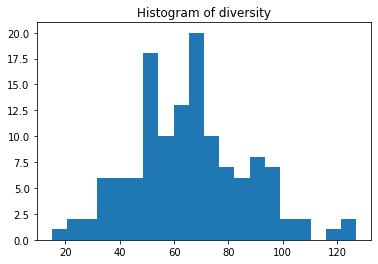

In [51]:
# calculate diversity of each participant in first 14 days
diversity = {}
for parID in food_dict_base.keys():
    df_temp = df_index.query('ParticipantID == @parID and DayPassed <= 14' )
    unique_food_num = len(df_temp['Parsed food'].unique())
    diversity[parID] = unique_food_num
diversity_value = diversity.values()    
_ = plt.hist(diversity_value, bins=20)
plt.title("Histogram of diversity")

In [52]:
df_diversity = pd.Series(diversity).to_frame()
df_diversity.rename({0:'diversity'}, axis='columns',inplace=True)
df_diversity.sort_values(by=['diversity'],inplace=True)
df_diversity.reset_index(inplace=True)
df_diversity.rename({'index':'ParticipantID'}, axis='columns',inplace=True)

In [53]:
# extract 5 participants of low, middle and high diversity
low_diversity = df_diversity[:5]
middle_diversity = df_diversity[62:67]
high_diversity = df_diversity[124:]
low_id = np.array(low_diversity['ParticipantID'])
mid_id = np.array(middle_diversity['ParticipantID'])
high_id = np.array(high_diversity['ParticipantID'])

In [54]:
middle_diversity

,ParticipantID,diversity
62,9bbi18060020,64
63,9bbi18060021,64
64,9bbi18060030,66
65,9bbi18100062,66
66,9bbi18070043,67


In [55]:
# for each people, generate a histogram, np.unique (return counts and sort), divide by the sum of food items; x axis: unique food items
# seaborn, histogram, density plot; facetgrid want all have the same y axis
# matplotshare y == true
# lowest 5, middle 5, highest 5

In [56]:
# method to generate dictionary used to plot participant's diet diversity
def generate_div(parID):
    
    a=np.array(df_index.query('ParticipantID==@parID and group == "baseline"')['Parsed food'])
    total_num = len(a)
    values, counts=np.unique(a,return_counts=True)
    div_dict = dict(zip(values,counts))
    div = dict(sorted(div_dict.items(), key=lambda x: x[1], reverse=True))
    return div,total_num
    

In [57]:
# method to generate dictionary with food items which appears more than once
def generate_div2(parID):
    
    a=np.array(df_index.query('ParticipantID==@parID and group == "baseline"')['Parsed food'])
    total_num = len(a)
    values, counts=np.unique(a,return_counts=True)
    div_dict = dict(zip(values,counts))
    div = dict(sorted(div_dict.items(), key=lambda x: x[1], reverse=True))
    div_subset = {key: value for key, value in div.items() if value > 1}

    return div_subset,total_num

Plot diversity barplot for the top5, middle5, and lowest 5 participants w.r.t their food diversity

X-axis indicates unique food items appeared in a person's diet, which is neglected for better visualization

Y-axis indicates density of each food item

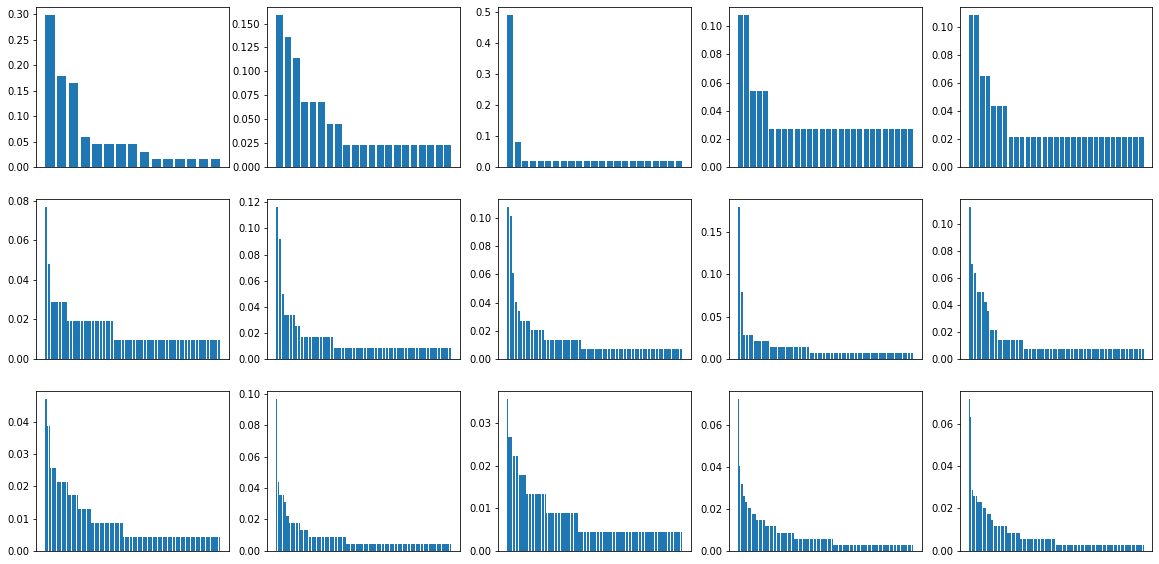

In [58]:
plt.figure(figsize=(20,10))
num_plot = 1
#low diversity
for parID in low_id:
    div,total_num = generate_div(parID)
    plt.subplot(3,5,num_plot)
    plt.bar(div.keys(), [x/total_num for x in div.values()])
    plt.xticks([])
    #axes[num_plot].set_xlabel("")
    num_plot +=1
#middle diversity
for parID in mid_id:
    div,total_num = generate_div(parID)
    plt.subplot(3,5,num_plot)
    plt.bar(div.keys(), [x/total_num for x in div.values()])
    plt.xticks([])
    num_plot +=1
#high diversity
for parID in high_id:
    div,total_num = generate_div(parID)
    plt.subplot(3,5,num_plot)
    plt.bar(div.keys(), [x/total_num for x in div.values()])
    plt.xticks([])
    num_plot +=1



Shared Y version of the above plot

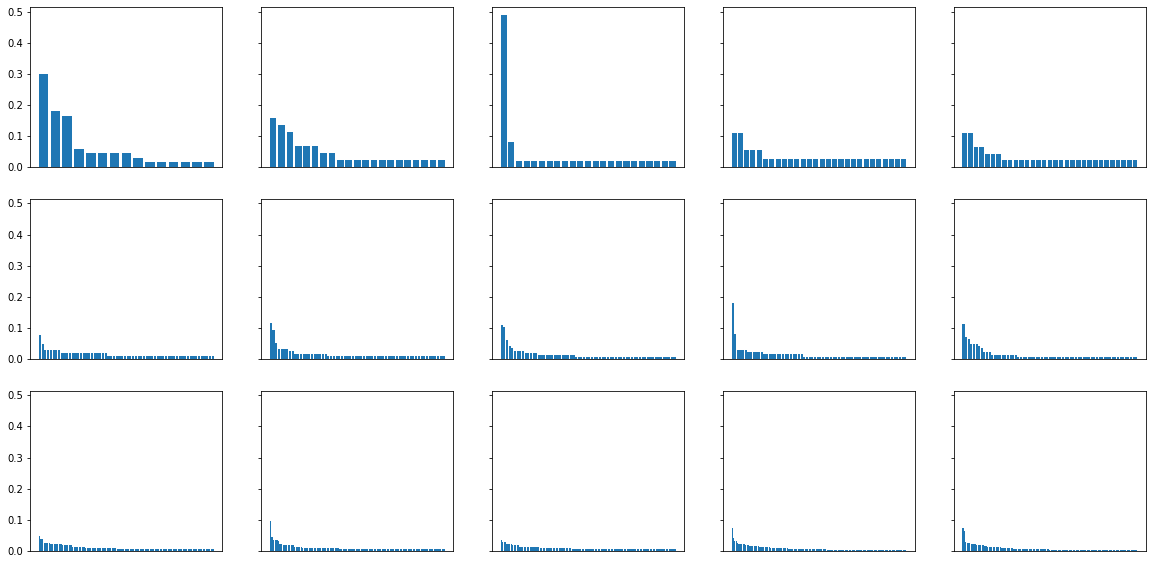

In [59]:

fig, ((ax1, ax2,ax3,ax4,ax5), (ax6, ax7,ax8,ax9,ax10),(ax11,ax12,ax13,ax14,ax15)) = plt.subplots(3, 5,sharey=True,figsize=(20,10))
num_plot = 1
for parID,ax in zip(low_id,[ax1,ax2,ax3,ax4,ax5]):
    div,total_num = generate_div(parID)
    
 
    ax.bar(div.keys(), [x/total_num for x in div.values()])
    ax.set_xticks([])
    num_plot +=1
for (parID,ax) in zip(mid_id,[ax6, ax7,ax8,ax9,ax10]):
    div,total_num = generate_div(parID)

    ax.bar(div.keys(), [x/total_num for x in div.values()])
    ax.set_xticks([])
    num_plot +=1
for (parID,ax) in zip(high_id,[ax11,ax12,ax13,ax14,ax15]):
    div,total_num = generate_div(parID)

    ax.bar(div.keys(), [x/total_num for x in div.values()])
    ax.set_xticks([])
    num_plot +=1




In [60]:
#visualize diveristy: denote number of unique items; display food name vertical; limit: frequency 1

In [75]:
#Plot diversity barplot for each individual. For better visualization, we exclude food item that appeared only once

#X-axis indicates unique food items appeared in a person's diet, which is neglected for better visualization

#Y-axis indicates density of each food item
def visualize_diversity(parID):
    plt.figure(figsize=(20,10))
    div,total_num = generate_div2(parID)
    plt.bar(div.keys(), [x/total_num for x in div.values()])
    plt.xticks(rotation='vertical')
    


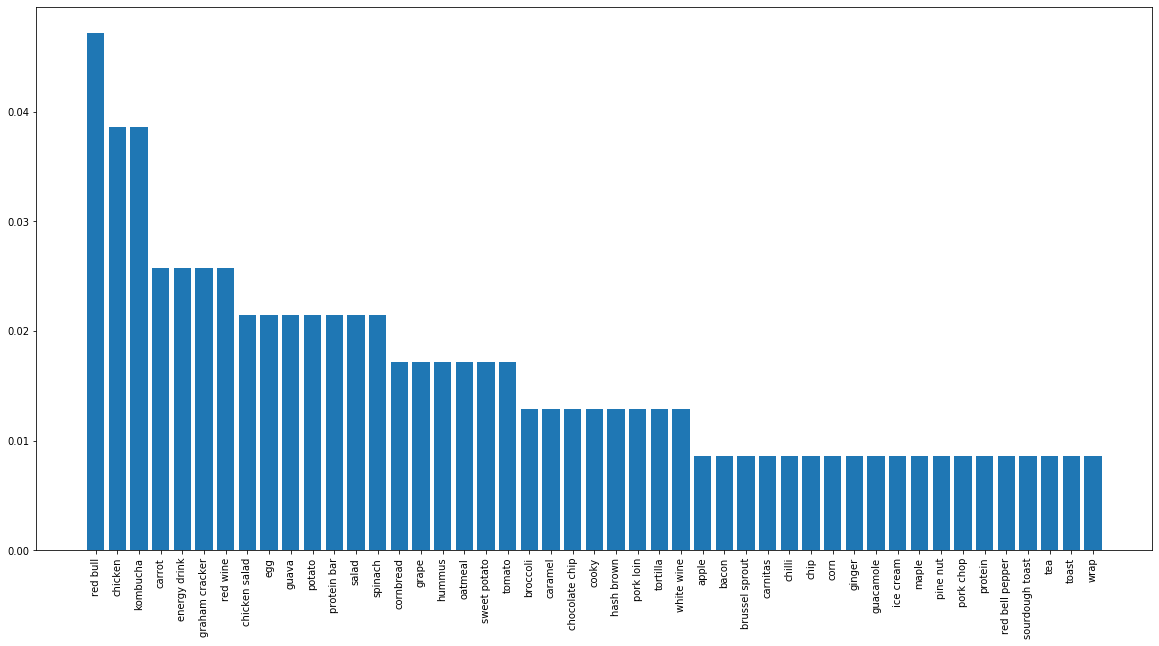

In [76]:
#participant from high-diversity group
visualize_diversity('9bbi18090058')

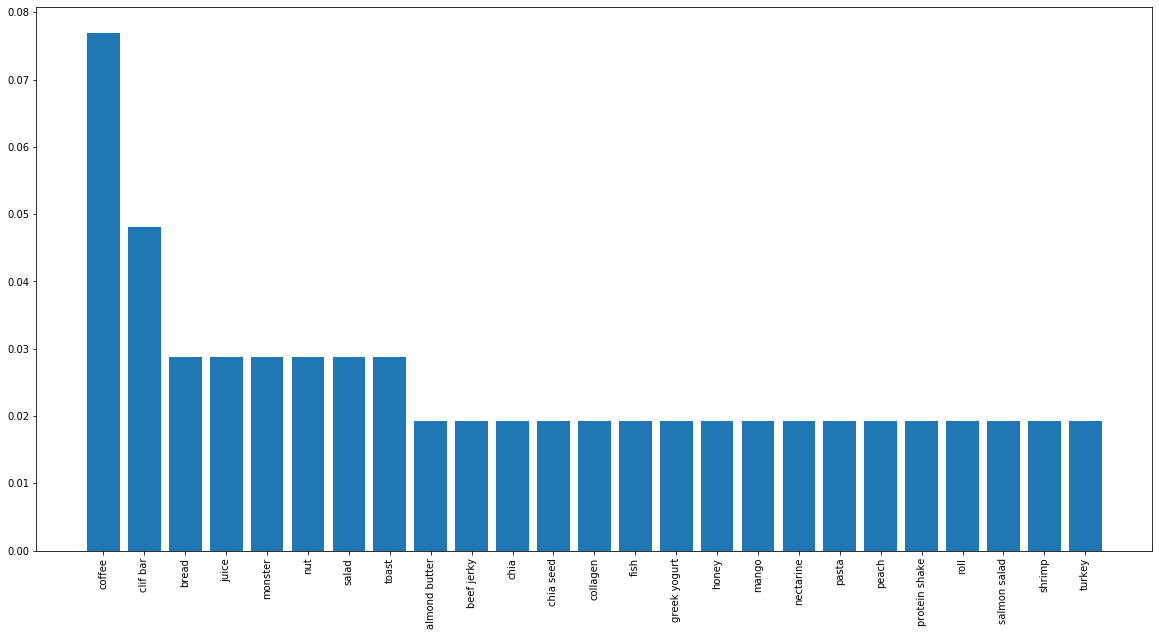

In [77]:
# participant from middle-diversity group 
visualize_diversity('9bbi18060020')

In [ ]:
# does tre change diversity
# diversity in intervention period

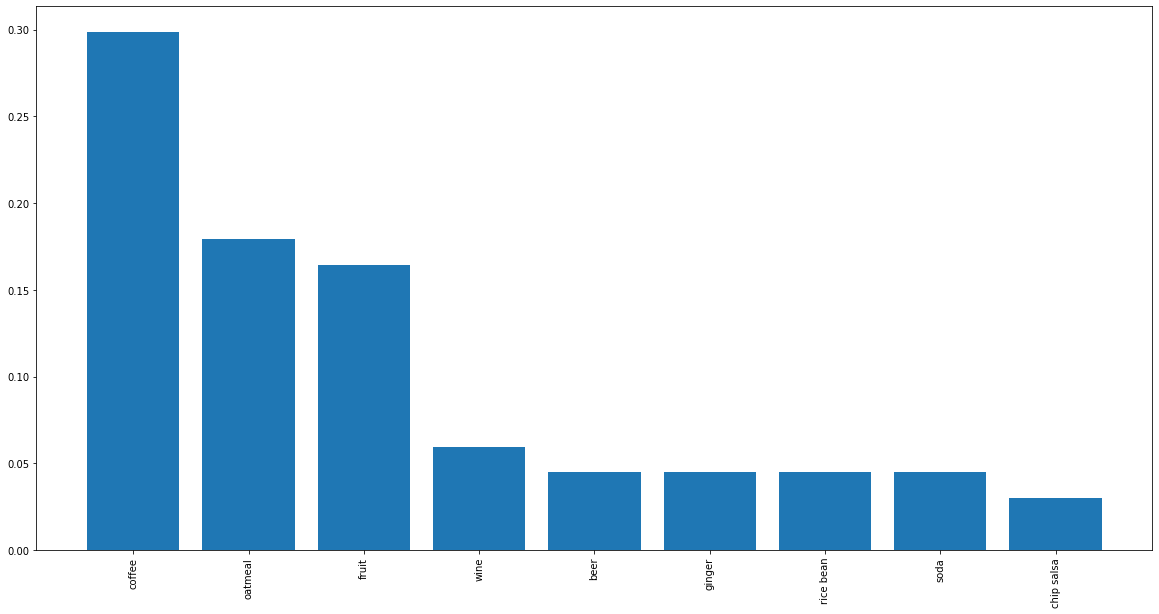

In [78]:
# participant from low diversity group
visualize_diversity('9bbi18070044')

In [ ]:
from sklearn.preprocessing import quantile_transform

In [ ]:
diversity

In [ ]:
pd.DataFrame(diversity)

In [ ]:
quantile_transform(pd.Series(diversity).to_frame().T)

In [ ]:
frame = pd.Series(diversity).sort_values().to_frame()

In [ ]:
frame

In [ ]:
df_index.query('ParticipantID == "9bbi19090151" and DayPassed <= 14') # outlier
# check whether all havr 14 days
# for each people, generate a histogram, np.unique (return counts and sort), divide by the sum of food items; x axis: unique food items
# seaborn, histogram, density plot; facetgrid want all have the same y axis
# matplotshare y == true
# lowest 5, middle 5, highest 5

In [ ]:
df.query('comparison == "7v14"')

FileNotFoundError: [Errno 2] File 4_movie_keywords does not exist: '4_movie_keywords'